In [2]:
import itertools
import random
import string
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random as rnd
import string
from pandas import DataFrame
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import utils


Train data shape: (27455, 785), Test data shape: (7172, 785)


(array([1126., 1010., 1144., 1196.,  957., 1204., 1090., 1013., 1162.,
           0., 1114., 1241., 1055., 1151., 1196., 1088., 1279., 1294.,
        1199., 1186., 1161., 1082., 1225., 1164., 1118.]),
 array([ 0.  ,  0.96,  1.92,  2.88,  3.84,  4.8 ,  5.76,  6.72,  7.68,
         8.64,  9.6 , 10.56, 11.52, 12.48, 13.44, 14.4 , 15.36, 16.32,
        17.28, 18.24, 19.2 , 20.16, 21.12, 22.08, 23.04, 24.  ]),
 <BarContainer object of 25 artists>)

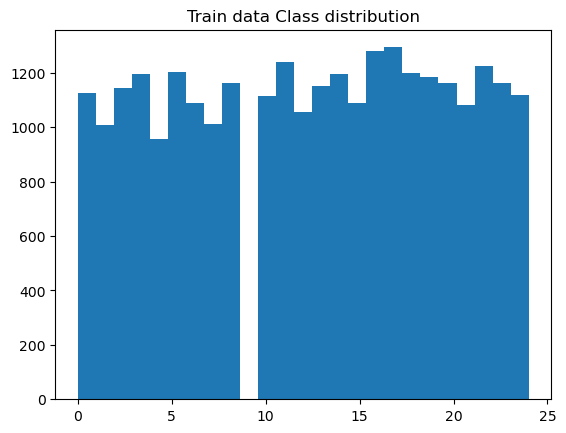

In [3]:
# reading in data

test_df = pd.read_csv('kaggleDataset/sign_mnist_test.csv')
train_df = pd.read_csv('kaggleDataset/sign_mnist_train.csv')

CLASS_COL = 'label'

print(f"Train data shape: {train_df.shape}, Test data shape: {test_df.shape}")

plt.title("Train data Class distribution")
plt.hist(train_df.label, bins=25)

In [4]:
def dataframe_to_array(dataframe):
    """ converts rows of df into np arrays. Returns feature rows, and labels
    """
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1.iloc[:, 1:].to_numpy()
    targets_array = dataframe1['label'].to_numpy()
    return inputs_array, targets_array

In [8]:
features, labels = dataframe_to_array(utils.normalizePixels(train_df))

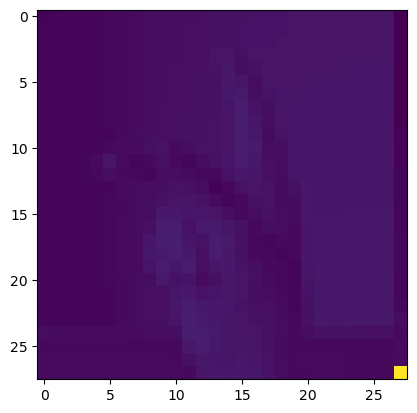

In [9]:
# rendering pixels in row
def row_to_img_grid(row):
    sqrt = int(np.sqrt(len(row)))
    return np.reshape(row, (sqrt, sqrt))


plt.imshow(row_to_img_grid(features[11]))



## Multinomial Naive Bayes


In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

clf = MultinomialNB()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

score = clf.score(X_test, y_test)
print(score)

0.539428155162994


(484,)


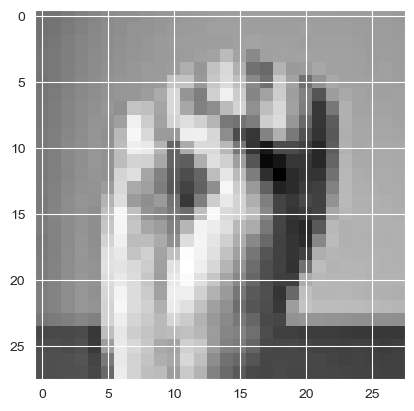

In [7]:
# trying to filter out background pixels

def crop_pixel_row(row, crop_size=3):
    img_grid = row_to_img_grid(row)
    img_grid = img_grid[crop_size:len(img_grid) - crop_size, crop_size:len(img_grid) - crop_size]
    rowLen = (len(img_grid)) ** 2
    return np.reshape(img_grid, rowLen)


# trying to crop image uniformly to increase accurcay
def apply_crop(features, crop_size=3):
    new_features = np.array([crop_pixel_row(row, crop_size=crop_size) for row in features])
    return new_features


row_filtered = crop_pixel_row(features[10])
print(row_filtered.shape)
plt.imshow(row_to_img_grid(features[10]), cmap="gray")

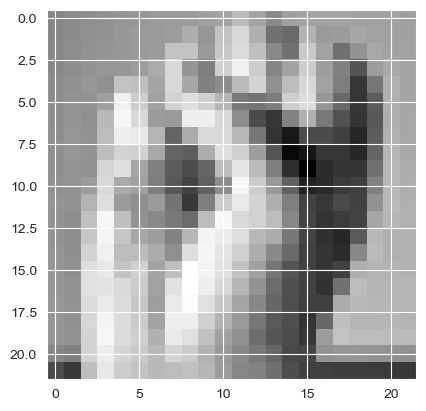

In [8]:
plt.imshow(row_to_img_grid(row_filtered), cmap="gray")

In [9]:
# k fold cross validation tuning by reducing layers of pixels

def do_nb(xtrain, ytrain, xtest, ytest):
    clf = MultinomialNB()
    clf.fit(xtrain, ytrain)
    score = clf.score(xtest, ytest)

    return score

cropSizes = list(range(10))
scores = []
k = 5

for cropSize in cropSizes:
    fold_scores = []
    filtered_x = apply_crop(X_train, crop_size=cropSize)
    for i in range(k):
        split_x = np.array([filtered_x[j] for j in range(len(filtered_x)) if j % k != i])
        split_y = np.array([y_train[j] for j in range(len(y_train)) if j % k != i])
        validation_split_x = np.array([filtered_x[j] for j in range(len(filtered_x)) if j % k == i])
        validation_split_y = np.array([y_train[j] for j in range(len(y_train)) if j % k == i])

        score = do_nb(split_x, split_y, validation_split_x, validation_split_y)
        fold_scores.append(score)
    scores.append(np.mean(fold_scores))

bestCropSize = cropSizes[np.argmax(scores)]


Best crop size: 3, Best Validation accuracy 0.565


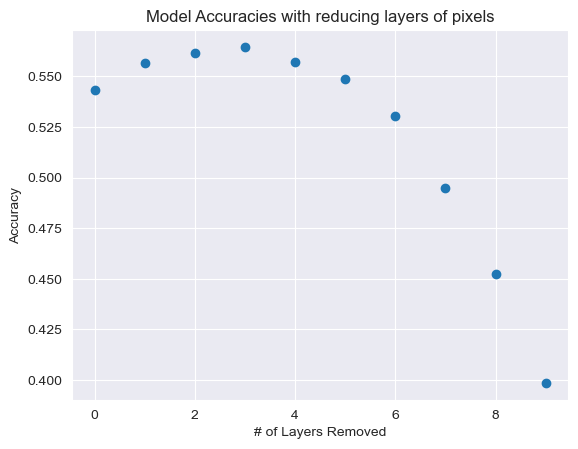

In [10]:
print(f"Best crop size: {bestCropSize}, Best Validation accuracy {round(max(scores), 3)}")
plt.title("Model Accuracies with reducing layers of pixels")
plt.xlabel('# of Layers Removed')
plt.ylabel("Accuracy")
plt.scatter(cropSizes, scores)

In [11]:
# applying best model parameters to a test set

# best cropsize is 3
filtered_x_train = apply_crop(X_train, crop_size=bestCropSize)
filtered_x_test = apply_crop(X_test, crop_size=bestCropSize)
best_test_accuracy = round(do_nb(filtered_x_train, y_train, filtered_x_test, y_test), 3)

print(f"Best test accuracy: {best_test_accuracy}")


Best test accuracy: 0.553


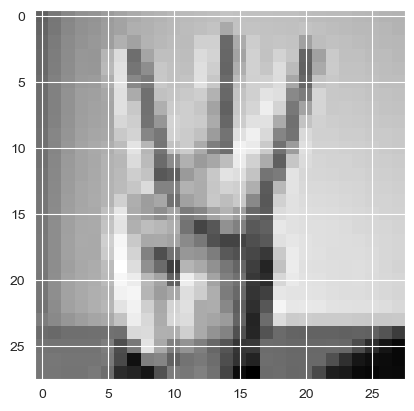

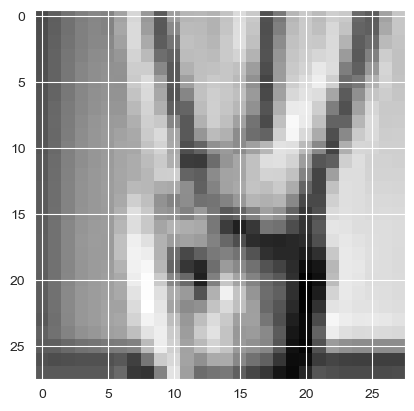

In [22]:
# random image crop augmentation
from PIL import Image
def random_crop(image, crop_height, crop_width):
    """Perform random crop augmentation on a 2D numpy array image."""

    # Get image shape and desired crop dimensions
    image_height, image_width = image.shape

    # Generate random coordinates for the top-left corner of the crop
    x = rnd.randint(0, image_width - crop_width)
    y = rnd.randint(0, image_height - crop_height)

    # Extract the crop from the image
    cropped_image = image[y:y+crop_height, x:x+crop_width]
    
    # converting to pillow image object and resizing back to original size
    imgObj = Image.fromarray(cropped_image.astype(np.uint8))
    imgObj = imgObj.resize((image_height, image_width))
    imgObj = np.array(imgObj)
    return imgObj

row = features[rnd.randint(1, len(features))]
plt.imshow(row_to_img_grid(row) , cmap='gray')
plt.show()
test_crop = random_crop(row_to_img_grid(row), 23, 23)
plt.imshow(test_crop, cmap='gray')
plt.show()

def apply_random_image_crop(X, crop_height, crop_width):
    
    def row_crop(row):
        img_grid = row_to_img_grid(row)
        img_grid = random_crop(img_grid, crop_height, crop_width)
        rowLen = (img_grid.shape[0]) ** 2
        return np.reshape(img_grid, rowLen)

    return np.array([row_crop(vec) for vec in X])

In [25]:
# random crop image for model

cropped_train = apply_random_image_crop(X_train, 24, 24)
best_random_crop_acc = do_nb(cropped_train, y_train, X_test, y_test)

print(f"Best random crop test accuracy : {best_random_crop_acc}")

Best random crop test accuracy : 0.4150427973046804
